In [20]:
import sys
sys.path.append('C:\Program Files\Python37\lib\site-packages')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [99]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding = 1)
        #self.conv2 = nn.Conv2d(16, 8, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(14*14*8, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 25)
        self.fc4 = nn.Linear(25, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [100]:
# Load training and testing sets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../../MNIST', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=100, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../../MNIST', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)

In [101]:
network = Net().cuda()
optimizer = optim.SGD(network.parameters(), lr=0.1,
                      momentum=0.5)

In [102]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        

In [103]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))

In [104]:
test()
for epoch in range(1, 11):
    train(epoch)
    test()


Test set: Avg. loss: 0.0662, Accuracy: 982/10000 (9%)

Test set: Avg. loss: -10.1603, Accuracy: 9684/10000 (96%)

Test set: Avg. loss: -10.1973, Accuracy: 9837/10000 (98%)

Test set: Avg. loss: -11.6428, Accuracy: 9845/10000 (98%)

Test set: Avg. loss: -12.7284, Accuracy: 9826/10000 (98%)

Test set: Avg. loss: -14.9852, Accuracy: 9843/10000 (98%)

Test set: Avg. loss: -14.5912, Accuracy: 9858/10000 (98%)

Test set: Avg. loss: -15.8657, Accuracy: 9875/10000 (98%)

Test set: Avg. loss: -17.0734, Accuracy: 9874/10000 (98%)

Test set: Avg. loss: -18.9045, Accuracy: 9859/10000 (98%)

Test set: Avg. loss: -20.1774, Accuracy: 9858/10000 (98%)


In [105]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [106]:
def test(model, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.cross_entropy(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [107]:
epsilons = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]

In [108]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(network,test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.1	Test Accuracy = 9499 / 10000 = 0.9499
Epsilon: 0.2	Test Accuracy = 8528 / 10000 = 0.8528
Epsilon: 0.3	Test Accuracy = 7513 / 10000 = 0.7513
Epsilon: 0.5	Test Accuracy = 5957 / 10000 = 0.5957
Epsilon: 0.7	Test Accuracy = 5018 / 10000 = 0.5018
Epsilon: 1.0	Test Accuracy = 4221 / 10000 = 0.4221


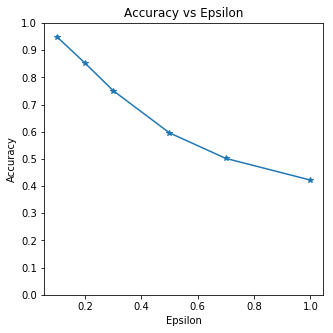

In [109]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

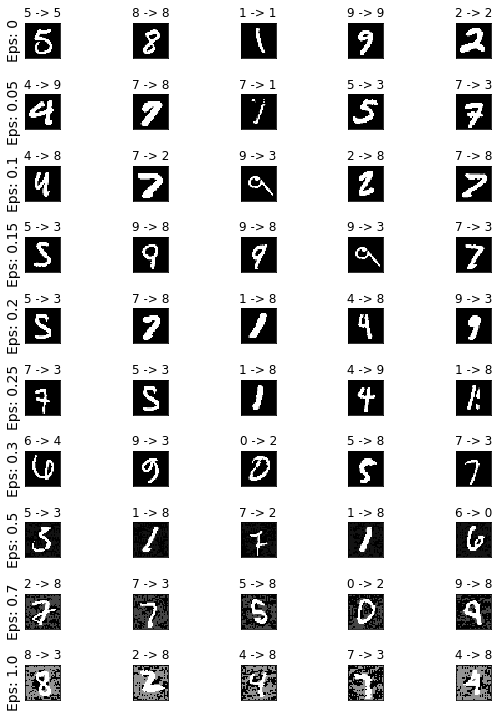

In [65]:
# Plot several examples of adversarial samples at each epsilon
count = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        count += 1
        plt.subplot(len(epsilons),len(examples[0]),count)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()